In [197]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


onwards_2016 = False
add_to_fig = "from_2016_onwards" if onwards_2016 else ""

First, we load the data and exclude Australia ( to far away), Marocco (only participated once) 
and Yugslawia and Serbia-Montenegro ( both historic states)

We check that all our data have values on the most simple points

In [198]:
# Load the data
votes = pd.read_csv("../data/fulldata.csv")

votes["round"] = votes["round"].astype("category")

votes = votes[votes["distance"] > 0]
votes = votes[votes["round"] == "final"]


votes = votes[votes["from_country"] != votes["to_country"]] #exclude self-votes
votes = votes[~votes["to_country"].isin(["au", "yu", "cs", "ma"])] # exclude Australia, Yugoslavia, Serbia and Montenegro, Morocco
votes = votes[~votes["from_country"].isin(["au", "yu", "cs", "ma"])] # exclude Australia, Yugoslavia, Serbia and Montenegro, Morocco
if onwards_2016:
    votes = votes[votes["year"] >= 2016] #exclude years before 2016

length_before = len(votes)
print("Rows before dropping NA Collums:", length_before)
votes.columns
votes = votes.dropna(subset=["from_country", "to_country", "distance", "total_points"])
length_after = len(votes)

print("Dropped", length_before - length_after, "rows due to missing values")

print("Rows before dropping NA after forcing numeric:", length_before)
length_before = length_after
print(votes.columns)

Rows before dropping NA Collums: 34061
Dropped 0 rows due to missing values
Rows before dropping NA after forcing numeric: 34061
Index(['Unnamed: 0', 'year', 'round', 'from_country', 'to_country',
       'total_points', 'tele_points', 'jury_points', 'Year_from',
       'iso-alpha-3_from', 'chrstprotpct_from', 'chrstcatpct_from',
       'chrstorthpct_from', 'judgenpct_from', 'islmgenpct_from',
       'nonreligpct_from', 'StateAbb_from', 'city_from', 'lat_from',
       'lon_from', 'GDP per capita (current US$)_from',
       'Population, total_from', 'Year_to', 'iso-alpha-3_to',
       'chrstprotpct_to', 'chrstcatpct_to', 'chrstorthpct_to', 'judgenpct_to',
       'islmgenpct_to', 'nonreligpct_to', 'StateAbb_to', 'city_to', 'lat_to',
       'lon_to', 'GDP per capita (current US$)_to', 'Population, total_to',
       'distance', 'jaccard_artists', 'jaccard_genre', 'dice_genre',
       'dice_artists'],
      dtype='object')


/tmp/ipykernel_8092/840765235.py:2: DtypeWarning: Columns (20,34) have mixed types. Specify dtype option on import or set low_memory=False.
  votes = pd.read_csv("../data/fulldata.csv")


Now we check if all the GDP data is actually numeric and drop rows that are not. We can track, how many  values are now missing. 
San Mario is missing GDP  values for 2023

In [199]:
votes
subset=["GDP per capita (current US$)_from", "GDP per capita (current US$)_to"]

length_before = len(votes)
votes.replace("..",float("nan"),inplace=True)

#print(votes['GDP per capita (current US$)_to'])
votes["GDP per capita (current US$)_from"] = pd.to_numeric(votes["GDP per capita (current US$)_from"], errors='coerce')
votes["GDP per capita (current US$)_to"] = pd.to_numeric(votes["GDP per capita (current US$)_to"], errors='coerce')
rows_with_na = votes[votes[subset].isna().any(axis=1)]

print("Rows with missing values:")
print(rows_with_na)
votes = votes.dropna(subset=subset)
length_after = len(votes)
print("Dropped", length_before - length_after, "rows due to missing values in GDP per capita")
print("Rows after dropping NA:", length_after)




Rows with missing values:
       Unnamed: 0  year  round from_country to_country  total_points  \
2               2  1960  final           at         mc             0   
14             14  1960  final           be         mc             0   
26             26  1960  final           dk         mc             2   
37             37  1960  final           fr         mc             3   
50             50  1960  final           de         mc             7   
...           ...   ...    ...          ...        ...           ...   
47241       47241  2023  final           sm         al             0   
47242       47242  2023  final           sm         pt             0   
47243       47243  2023  final           sm         rs             0   
47244       47244  2023  final           sm         gb             0   
47245       47245  2023  final           sm         de             0   

       tele_points  jury_points  Year_from iso-alpha-3_from  ...   city_to  \
2              NaN          NaN

The religios data does not include Serbia, so we can right  anywway.
As you can see for 2016>= the relgion data is complete otherwise

In [200]:
#Compute difference so that we can use that as varible in the regression

votes["GDP_Difference"] = votes["GDP per capita (current US$)_from"] - votes["GDP per capita (current US$)_to"]

if onwards_2016:
    # we know that this data is incomplete , so we will only look at newer data, where we have more complete data
    religious_differences = ["Catholism_Difference", "Protestant_Difference", "Islam_Difference", "Judaism_Difference"]
    votes = votes[~votes["from_country"].isin(["rs"])] #exclude Serbia
    votes = votes[~votes["to_country"].isin(["rs"])] #exclude Serbia

    
    votes["Catholism_Difference"] = votes["chrstcatpct_from"] - votes["chrstcatpct_to"]

    votes["Protestant_Difference"] = votes["chrstprotpct_from"] - votes["chrstprotpct_to"]

    votes["Islam_Difference"] = votes["islmgenpct_from"] - votes["islmgenpct_to"]

    votes["Judaism_Difference"] = votes["judgenpct_from"] - votes["judgenpct_to"]

    length_before = len(votes)
    print("Rows before dropping NA Collums:", length_before)

    rows_with_na = votes[votes[religious_differences].isna().any(axis=1)]

    print("Rows with missing values:")
    print(rows_with_na)
    votes = votes.dropna(subset=["Catholism_Difference", "Protestant_Difference", "Islam_Difference", "Judaism_Difference"])
    length_after = len(votes)
    print("Dropped", length_before - length_after, "rows due to missing values in religion data")

In [201]:
votes.head

<bound method NDFrame.head of        Unnamed: 0  year  round from_country to_country  total_points  \
0               0  1960  final           at         fr             1   
1               1  1960  final           at         gb             3   
3               3  1960  final           at         no             1   
4               4  1960  final           at         de             2   
5               5  1960  final           at         be             1   
...           ...   ...    ...          ...        ...           ...   
47416       47416  2023  final           gb         si             1   
47417       47417  2023  final           gb         al             0   
47418       47418  2023  final           gb         pt             0   
47419       47419  2023  final           gb         rs             0   
47420       47420  2023  final           gb         de             0   

       tele_points  jury_points  Year_from iso-alpha-3_from  ...  \
0              NaN          NaN      

We normalize the continous variable to better compare effect size

In [202]:
votes["distance"] = votes["distance"].astype("int")

#Normalize the data
votes["distance"] = (votes["distance"] - votes["distance"].mean()) / votes[
    "distance"
].std()
votes["GDP_Difference"] = (votes["GDP_Difference"] - votes["GDP_Difference"].mean()) / votes[
    "GDP_Difference"
].std()

if onwards_2016:
    votes["Catholism_Difference"] = (votes["Catholism_Difference"] - votes["Catholism_Difference"].mean()) / votes[
        "Catholism_Difference"
    ].std()
    votes["Protestant_Difference"] = (votes["Protestant_Difference"] - votes["Protestant_Difference"].mean()) / votes[
        "Protestant_Difference"
    ].std()
    votes["Islam_Difference"] = (votes["Islam_Difference"] - votes["Islam_Difference"].mean()) / votes[
        "Islam_Difference"
    ].std()
    votes["Judaism_Difference"] = (votes["Judaism_Difference"] - votes["Judaism_Difference"].mean()) / votes[
        "Judaism_Difference"
    ].std()


In [ ]:
if onwards_2016:
    print("Running model with religion data")
    mixed_model = smf.mixedlm(
        formula="total_points ~ distance + GDP_Difference + Catholism_Difference + Protestant_Difference + Islam_Difference + Judaism_Difference + dice_genre + dice_artists",
        data=votes,
        groups=votes["from_country"],
    ).fit()
else:
    print("Running model without religion data")
    mixed_model = smf.mixedlm(
        formula="total_points ~ distance + GDP_Difference + dice_genre + dice_artists",
        re_formula='~distance', 
        data=votes,
        groups=votes["from_country"],
    ).fit()
    
print(mixed_model.summary())

Running model without religion data
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_points
No. Observations: 33700   Method:             REML        
No. Groups:       47      Scale:              17.0075     
Min. group size:  170     Log-Likelihood:     -95614.7893 
Max. group size:  1243    Converged:          Yes         
Mean group size:  717.0                                   
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       2.590    0.076  34.046 0.000  2.441  2.739
distance       -0.505    0.027 -18.663 0.000 -0.558 -0.452
GDP_Difference  0.083    0.028   2.994 0.003  0.029  0.138
dice_genre     -0.121    0.193  -0.629 0.530 -0.500  0.257
dice_artists    1.152    0.184   6.251 0.000  0.791  1.513
Group Var       0.137    0.009                            



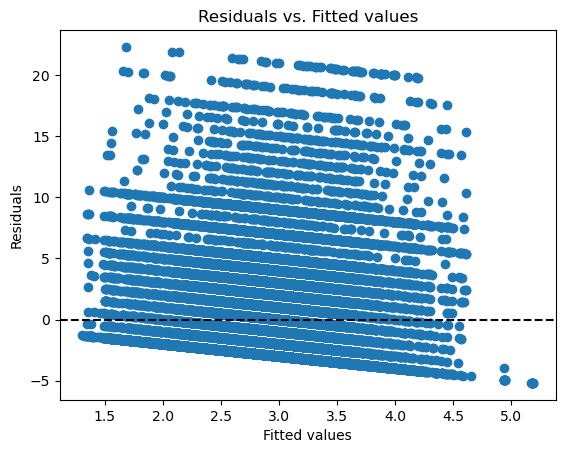

In [204]:
votes["residuals"] = mixed_model.resid
votes["fitted_values"] = mixed_model.fittedvalues

# Plot the residuals
plt.scatter(votes["fitted_values"], votes["residuals"])
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted values")
plt.axhline(y=0, color="black", linestyle="--")
plt.show()

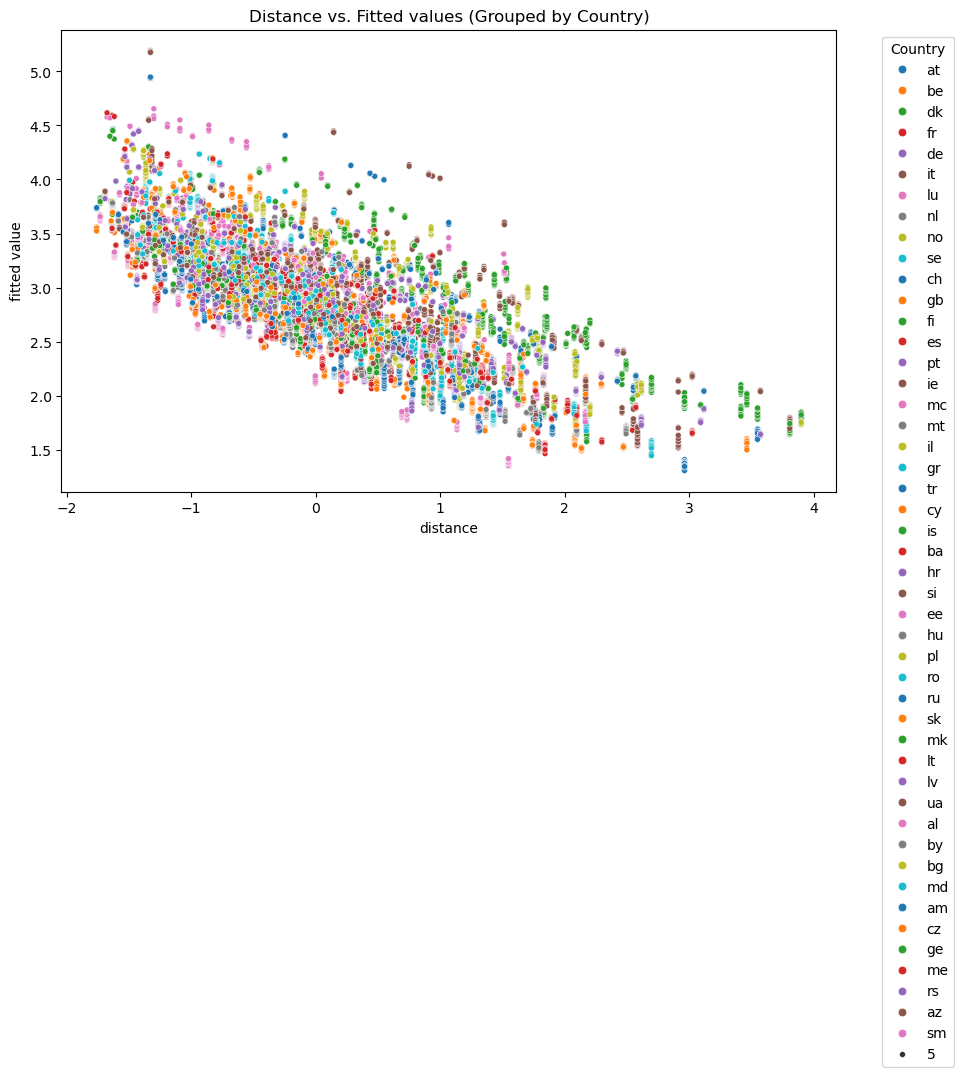

In [205]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'votes' has a column 'country' for grouping
sizes = [5 for _ in range(len(votes))]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=votes, 
    x="distance", 
    y="fitted_values", 
    hue="from_country",  # Group by country
    size=sizes, 
    palette="tab10"  # Use a predefined palette
)
plt.xlabel("distance")
plt.ylabel("fitted value")
plt.title("Distance vs. Fitted values (Grouped by Country)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



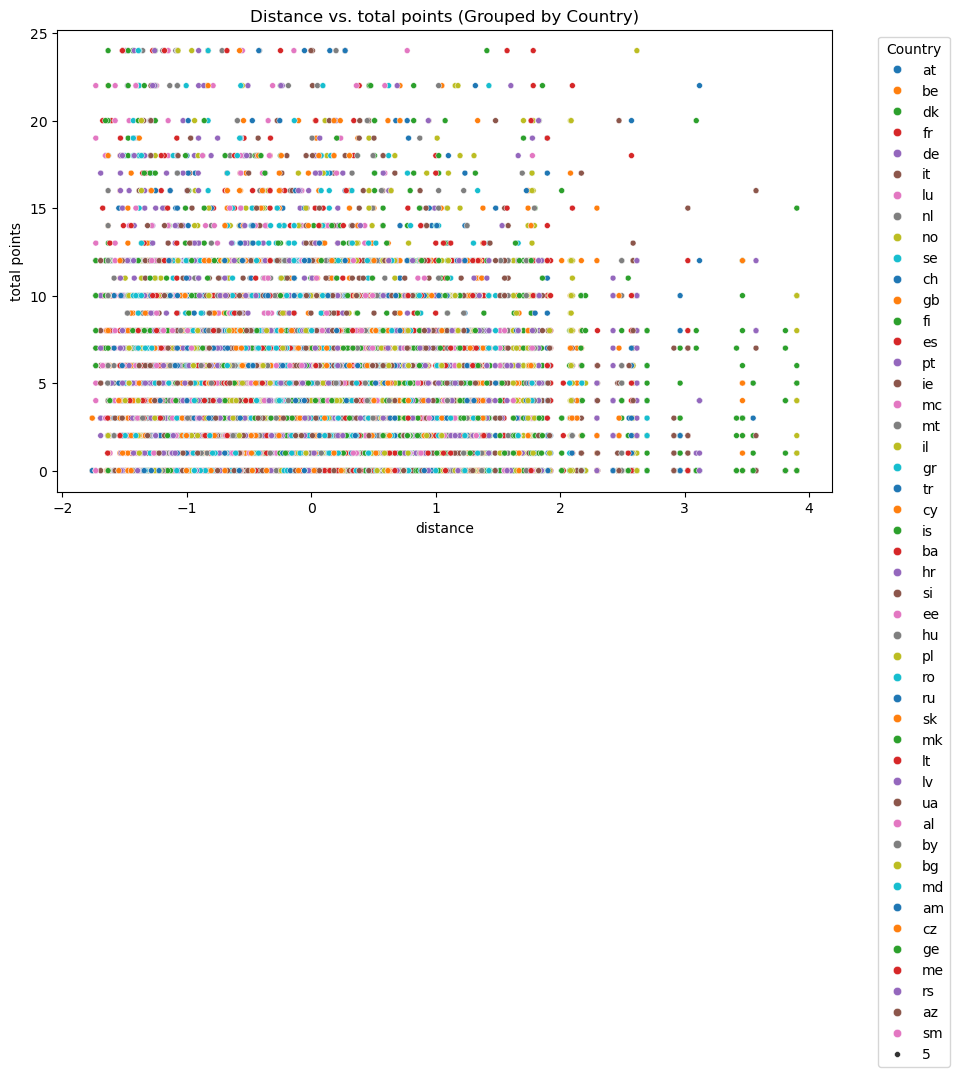

In [206]:
# Assuming 'votes' has a column 'country' for grouping
sizes = [5 for _ in range(len(votes))]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=votes, 
    x="distance", 
    y="total_points", 
    hue="from_country",  # Group by country
    size=sizes, 
    palette="tab10"  # Use a predefined palette
)
plt.xlabel("distance")
plt.ylabel("total points")
plt.title("Distance vs. total points (Grouped by Country)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

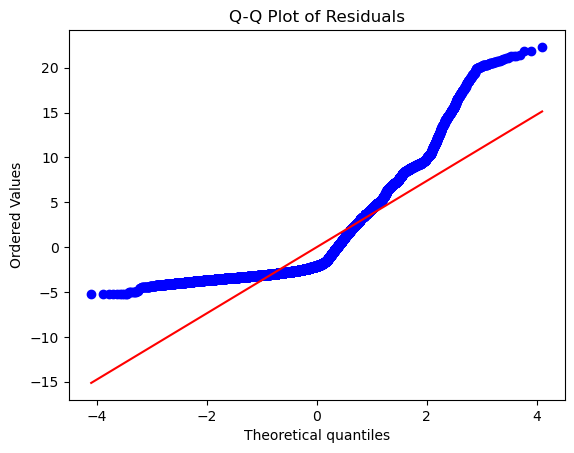

In [207]:
import scipy.stats as stats
stats.probplot(votes["residuals"], dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


As we can see, the residuals clearly don't follow a normal distribution. Therefore our analysis should be regarded with caution

/tmp/ipykernel_8092/2564329060.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


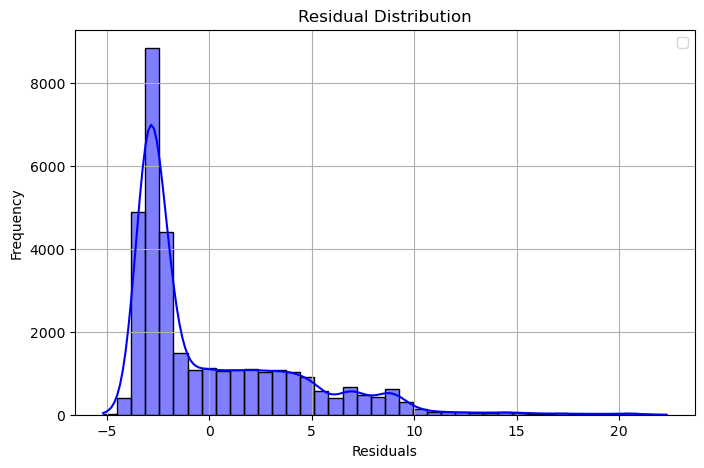

In [208]:
plt.figure(figsize=(8, 5))
sns.histplot(votes["residuals"], bins=40, color="blue", alpha=0.5, kde=True)

plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.legend()
plt.grid(True)

plt.savefig(f"../plots/linear_effects/residuals_{add_to_fig}.png")
plt.show()